# Slice Sampling

Slice Sampling {cite}`neal2003slice` is a Markov Chain Monte Carlo (MCMC) method for sampling from unnormalised probability distributions. Like any other MCMC method, Slice Sampling starts out from an initial point $x_n$ and evolves this according to a stochastic transition rule, $p(x_{n + 1} | x_n)$, such that the distribution of $x_n$ approaches a target distribution in the limit $n \to \infty$.

Unlike many other MCMC methods, Slice Sampling has two very nice features which make it interesting. First, it involves very few tunable parameters and is relatively robust to different settings of these parameters. This is typically not so for other MCMC methods such as simple Metropolis Hastings, where the choice of proposal distribution can greatly affect the performance of the algorithm. The second feature, which is related to the first, is that Slice Sampling is adaptive. In other words, the Slice Sampling transition rule adapts to the shape of the distribution at the region it is trying to sample.

In [14]:
from IPython.display import HTML, set_matplotlib_formats
from IPython.display import Image

set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

## An idealised Slice Sampling algorithm

Slice Sampling is based on the observation that sampling a point $(x, y)$ (where $x \in \mathbb{R}^D, y\in \mathbb{R}$) uniformly from the area under an unnormalised probability density function $f(x)$, and discarding the vertical $y$ coordinate, yields an exact sample $x \sim p(x) \propto f(x)$. This is illustrated in the image below. In order to sample from the Gaussian on the (left), we sample points uniformly at random from the area under its unnormalised density $f(x)$ (middle). The resulting points are exact samples from the normalised Gaussian (right).

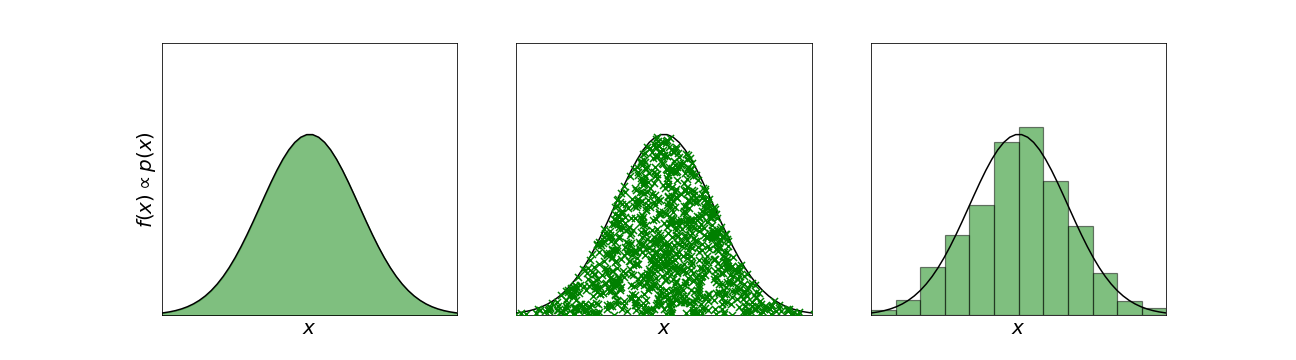

In [16]:
Image(filename='./img/motivating.png')

Stating the problem this way has not made it any easier, because sampling $(x, y)$ from the area under the curve is just as hard as sampling $p(x)$ itself. Slice Sampling makes progress by observing that we can define a Markov Chain in this augmented $(x, y)$ space and set it up so that this augmented chain converges to a uniform in the area under $f(x)$ - this is in contrast to conventional MCMC algorithms which work in $x$-space only.

Here is how we can set up this chain. Given an initial point $x_n$ (dashed line below) we can generate the next point $x_{n+1}$ by first sampling $y \sim \text{Uniform}[0, f(x_n)]$. This gives a point $(x_n, y)$ in the augmented space (black cross) whose $y$-coordinate defines a *slice* $S_y = \{x : y = f(x)\}$ (thick black line). We can sample a point uniformly at random from this slice, $x_{n+1} \sim \text{Uniform}[S_y]$, to obtain a new point $(x_{n+1}, y)$ (green cross). Lastly, by discarding the $y$ coordinate, we are left with a new point $x_{n+1}$ (green dashed line).

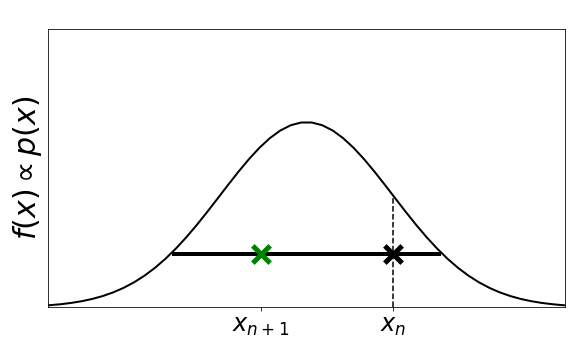

In [17]:
Image(filename='./img/idealised.png')

This transition procedure leaves the target distribution invariant. Furthermore, if the target distribution is positive everywhere, the resulting Markov Chain is guaranteed to converge to it. However, the issue with this algorithm is that in general, there is no straightforward way to sample from $S_y$. The slice $S_y$ is a union of intervals, each of which has endpoints corresponding to solutions of the equation $f(x) - y = 0$, for which there may not be a closed form. In addition, the slice is not guaranteed to be bounded, as it could be for example a union of ever-smaller and ever far apart intervals, whose union is unbounded. The Slice Sampling alogorithm below circumvents both these issues.

## The Slice Sampling algorithm

To deal with the aforementioned issues, Slice Sampling defines a finite interval $I$ and a set $A$ and samples the new point $x_{n+1}$ uniformly from $S_y \cap I \cap A$ instead of $S_y$ - the definition and role of the set $A$ will be clarified shortly. Since the interval $I$ is finite, so will be $S_y \cap I \cap A$. This deals with the problem of boundedness of the set we are sampling from. Now in order to deal with the issue that the slice is not available in closed form, we can simply draw repeated samples from $I$ until one falls in $S_y \cap A$. This accepted sample will be a uniform sample from $S_y \cap I \cap A$.

Depending on the choice of $I$, a corresponding set $A$ may be needed in order to ensure that the transition rule leaves the target distribution invariant. More precisely, $A$ is defined as the set

$$A = \{x_{n+1} : p(x_{n+1} | x_n, y) = p(x_n | x_{n+1}, y)\}$$

for which transitions from $(x_n, y)$ to $(x_{n+1}, y)$ has the same probablity as a transition from $(x_{n+1}, y)$ to $(x_n, y)$. Therefore $A$ depends on the precise way in which $I$ is defined. There are several possible ways to define the set $I$, and in this page we will have a look at two methods proposed by by Neal. For these choices, determing whether a point $x_{n+1}$ is in $A$ is a computationally cheap check. In summary, here is the full Slice sampling algorithm for one dimension.

<div class='definition'>

**Definition (One dimensional slice sampling)** Given an unnormalised target distribution $f(x)$ and a current point $x_n$, slice sampling generates a new point $x_{n+1}$ as follows:
    
1. Sample $y \sim \text{Uniform}[0, f(x_{n})]$. This defines the slice set $S_y = \{x : y = f(x)\}.$
2. Generate a finite interval $I$ that contains $x_{n}$.
3. Sample $x_{n+1}$ uniformly from the set of intervals $S_y \cap I \cap A$, where
    
$$A = \{x_{n+1} : p(x_{n+1} | x_n, y) = p(x_n | x_{n+1}, y)\}.$$
    
</div>
<br>
    
Neal considers two possible definitions for $I$, namely the step-out method and the doubling method. We'll look at the step-out and the doubling methods in more detail and provide proofs of the related results.

Note also that the above algorithm is a special case of the more general "crumb" framework.{cite}`neal2003slice` Crumb-based slice sampling is not constained to generating an $I$ and sampling from a subset of it, although methods that do so can be cast as crumb-based methods. Crumb-based methods are very general and therefore ammeanable to a great deal of tuning and design choices, which are beyond the scope of this page, so we won't look into them.

It can be shown that the sampling algorithm defined above leaves the target distribution invariant. To show this, it is enough to show that slice sampling satisfies detailed balance.

<div class='lemma'>

**Result (Slice sampling satisfies detailed balance)** The slice-sampling transition rule satisfies detailed balance
    
$$\begin{align}
p(x_{n+1} | x_n) \pi(x_n) = p(x_n | x_{n+1}) \pi(x_{n+1}).
\end{align}$$
    
</div>
<br>


<details class="proof">
<summary> Proof: Slice sampling satisfies detailed balance </summary>

We will show that slice sampling satisfies detailed balance of the target distribution. We have
$$\begin{align}
p(x_{n+1} | x_n)\pi(x_n) &= \int_0^{\pi(x_n)} p(x_{n+1} | x_n, y) p(y | x_n) \pi(x_n) dy \\
                     &= \int_0^{\pi(x_n)} p(x_{n+1} | x_n, y) \frac{1}{\pi(x_n)} \pi(x_n) dy \\
                     &= \int_0^{\min(\pi(x_n), \pi(x_{n+1}))} p(x_{n+1} | x_n, y) dy,
\end{align}$$
where in the last line we have used the fact that
$$\begin{align}
p(x_{n+1} | x_n, y) = 0, \text{ whenever } y > \pi(x_{n+1}).
\end{align}$$
    
Similarly, going the other way we have
$$\begin{align}
p(x_n | x_{n+1})\pi(x_{n+1}) &= \int_0^{\pi(x_{n+1})} p(x_n | x_{n+1}, y) p(y | x_{n+1}) \pi(x_{n+1}) dy \\
                     &= \int_0^{\pi(x_{n+1})} p(x_n | x_{n+1}, y) \frac{1}{\pi(x_{n+1})} \pi(x_{n+1}) dy \\
                     &= \int_0^{\min(\pi(x_n), \pi(x_{n+1}))} p(x_n | x_{n+1}, y) dy.
\end{align}$$
Therefore, we only need to show that
$$\begin{align}
p(x_{n+1} | x_n, y) &= p(x_n | x_{n+1}, y),
\end{align}$$
which is follows by the definition of $A$. In particular, since $x_{n+1}$ is sampled from $S_y \cap A \cap I$, it will be in $A$. Since $A$ is defined as
$$A = \{x_{n+1} : p(x_{n+1} | x_n, y) = p(x_n | x_{n+1}, y)\},$$
it follows that $p(x_{n+1} | x_n, y) = p(x_n | x_{n+1}, y)$. This proof in offloads a bit of the work to the definition of $A$, which we will discuss shortly.
    
</details>
<br>

## Interval-expansion methods

Neal proposes two methods for computing the finite interval $I$: the step-out method and the doubling method. We discuss each in turn.

### Step-out method

<div class='definition'>

**Definition (Step-out method)** Given $f, x_n, y$, positive integer $m$ and positive real $w > 0$, the step-out method produces an interval $I = [L, R]$ containing $x_n$ as follows
    
1. Sample $U, V \sim \text{Uniform}[0, 1]$.
2. Initialise endpoints $L = x_n - wU$ and $R = x_n + w$, and budgets $N_L = \text{floor}(mV)$ and $N_R = (m - 1) - N_L$.
3. While $N_L > 0$ and $y \leq f(L)$ update $L \leftarrow L - w$, $N_L \leftarrow N_L - 1$.
4. While $N_R > 0$ and $y \leq f(R)$ update $R \leftarrow R + w$, $N_R \leftarrow N_R - 1$.
    
</div>
<br>

This process expands $I$ to the left and to the right, terminating the expansion in each direction when it finds an endpoint outside the slice, or when the budget is used up. Selecting $U, V$ at random is of crucial importance in ensuring that the resulting $A$ is not too restrictive.

In [10]:
def step_out_expansion(x0, y, log_prob, w, m):
    
    U = np.random.rand()
    L = x0 - w * U
    R = L + w
    
    Lhist = [L]
    Rhist = [R]
    
    J = np.floor(m * np.random.rand())
    K = m - 1 - J
    
    fL = log_prob(L)
    fR = log_prob(R)
    
    while J > 0 and y <= fL:
        
        L = L - w
        J = J - 1
        fL = log_prob(L)
        
        Lhist.append(L)
        
    while K > 0 and y <= fR:
        
        R = R + w
        K = K - 1
        fR = log_prob(R)
        
        Rhist.append(R)
        
    return L, R, (Lhist, Rhist)

### Doubling method

<div class='definition'>

**Definition (Doubling method)** Given $f, x_n, y$, positive integer $p$ and positive real $w > 0$, the step-out method produces an interval $I = [L, R]$ containing $x_n$, as follows
    
1. Sample $U \sim \text{Uniform}[0, 1]$.
2. Initialise endpoints $L = x_n - wU$ and $R = x_n + w$ and budget $K = p$.
3. While $K > 0$ and $(y < f(L) \text{ or } y < f(R))$, sample $V \sim \text{Uniform}[0, 1]$ and update 
    
    $$\begin{align}
L \leftarrow L - (R - L) &&\text{ if } V < \frac{1}{2} \\
R \leftarrow R + (R - L) &&\text{ otherwise}.
\end{align}$$
    
</div>
<br>

In [11]:
def double_expansion(x0, y, log_prob, w, p):
    
    U = np.random.unform()
    L = x0 - w * U
    R = L + w
    K = p
    
    Lhist = [L]
    Rhist = [R]
    
    fL = log_prob(L)
    fR = log_prob(R)
    
    while K > 0 and (fL > y or fR > y):
        
        V = np.random.uniform()
        
        if V > 0.5:
            L = L - (R - L)
            fL = log_prob(L)
            
        else:
            R = R + (R - L)
            fR = log_prob(R)
        
        Lhist.append(L)
        Rhist.append(R)
        
        K = K - 1
            
    return L, R, (Lhist, Rhist)

## Interval sampling

### Sampling method

<div class='lemma'>

**Result (Acceptable sets for step-out/doubling methods)** Starting from the point $x_n$, the acceptable set
    
$$A = \{x_{n+1} : p(x_{n+1} | x_n, y) = p(x_n | x_{n+1}, y)\}$$
    
is equal to $S \cap I$ for the step-out method, where $I$ is the interval expanded from $x_n$ using parameters $w, p$. For the doubling method, we can determine whether a candidate point $x_{n+1}$ is in the acceptable set defined by $x_n, y, w, p, I$ as follows
    
1. Initialise $[L, R] = I$.
2. While $R - L > w$ repeat

    2.1 Set $M = (L + R)~/~2$, and update $L, R$ according to
    
    $$\begin{align}
L \leftarrow M &&\text{ if } M \geq x_n \\
R \leftarrow M &&\text{ otherwise}.
\end{align}$$
    
    2.2 If $y \geq f(L)$ and $y \geq f(R)$, $x$ is not acceptable.
3. If $x$ is not rejected in the above loop, it is acceptable.
    
</div>
<br>

In [18]:
def sample_acceptable_set(x0, y, L, R, log_prob, method, params, shrinkage):
    
    L0, R0 = L, R
    
    while True:
        
        x = L + (R - L) * np.random.rand()
        
        accept = is_acceptable(x, y, L0, R0, log_prob, method, params)
        
        if accept:
            return x
        
        elif shrinkage and x < x0:
            L = x
            
        elif shrinkage and x > x0:
            R = x

### Checking for acceptibility

In [19]:
def is_acceptable(x, y, L, R, log_prob, method, params):
    
    # Function value at candidate point
    f = log_prob(x)
    
    # For stepping out, check x is in the slice (y < f)
    if method == 'step_out':
        
        if y <= f:
            return True
        
        else:
            return False
    
    # For doubling, check the doubling sequence can be recreated the other way
    elif method == 'double':
        
        w, p = params
        
        fx = log_prob(x)
        
        while R - L > 1.5 * w:
            
            M = (R + L) / 2
            
            fL = log_prob(L)
            fM = log_prob(M)
            fR = log_prob(R)
            
            if x >= M and (y < fM or y < fR): L = M
                
            elif x < M and (y < fL or y < fM): R = M
            
            else: return False
            
        # If the point is not rejcected in the loop, it is acceptable
        return True

## The Slice Sampling algorithm

Putting it all together, we have a complete MCMC algorithm for sampling from $1$-dimensional distributions.

In [20]:
def sample(x0, log_prob, method, params, shrinkage):
    
    f0 = log_prob(x0)
    y = np.log(np.exp(f0) * np.random.rand())
    
    L = None
    R = None
    
    if method == 'step_out':
        w, m = params
        L, R, _ = step_out_expansion(x0, y, log_prob, w, m)
        
    elif method == 'double':
        w, p = params
        L, R, _ = double_expansion(x0, y, log_prob, w, p)
        
    x = sample_acceptable_set(x0=x0,
                              y=y,
                              L=L,
                              R=R,
                              log_prob=log_prob,
                              method=method,
                              params=params,
                              shrinkage=shrinkage)
    
    return x, y

## References

```{bibliography} ./references.bib
```